# Adaptive gains
This script will see how the adaptive algorithm out-preforms the passive algorithm.

It does this by seeing how many rankings are considered the funniest ranking. For each caption we have a mean and a standard deviation. If the first rated caption has mean $\mu_1$ and std.dev. of $\sigma_1$, we want how many captions $i$ have $\mu_i + \sigma_i > \mu_1 - \sigma_1$.

## Obtaining the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [10]:
contest = '519'
filename = '../contests/responses-unzipped/{}-responses.csv'

df = pd.read_csv(filename.format(contest))
df = df.sort_values(by='timestamp_query_generated')
df.head()

,Unnamed: 0,alg_label,network_delay,participant_uid,response_time,target,target_id,target_reward,timestamp_query_generated
49163,49163,LilUCB,0.195137,3302355eaaa9db3a30917035434dfa_J2IRIqVgmQ0IuP9...,18.287,This ought to be good. I told him he's a prote...,1062,1.0,2016-04-25 16:18:25.909958
49164,49164,LilUCB,0.095659,3302355eaaa9db3a30917035434dfa_J2IRIqVgmQ0IuP9...,2.827,The old birds are tricky.,176,1.0,2016-04-25 16:18:44.728593
49165,49165,LilUCB,0.088640,3302355eaaa9db3a30917035434dfa_J2IRIqVgmQ0IuP9...,4.018,He's never been clear on the decoy concept.,4311,2.0,2016-04-25 16:18:47.975493
34582,34582,LilUCB,0.083091,3302355eaaa9db3a30917035434dfa_HXWpEcL3w1PZi1M...,8.905,That little bird won't tell him very much if h...,3500,1.0,2016-04-25 16:22:41.837991
34583,34583,RoundRobin,0.092276,3302355eaaa9db3a30917035434dfa_HXWpEcL3w1PZi1M...,2.233,He doesn't play well with others.,0,1.0,2016-04-25 16:22:51.155561


## Finding the mean and number of possible top captions 
Another implementation can be found in `/summary-stats/summary-stats-v2.py`.

In [25]:
def calculate_stats(alg_ratings):
    df = pd.DataFrame(alg_ratings).T
    n = df['responses']
    df['mean'] = df[1.0] + 2 * df[2.0] + 3 * df[3.0]
    df['mean'] /= n
    
    reward =  df[1.0] + 2*df[2.0] + 3*df[3.0]
    reward2 = df[1.0] + 4*df[2.0] + 9*df[3.0]
    
    top = np.maximum(1, reward2 - reward**2 / n)
    bottom = (n - 1) * n
    
    df['prec'] = np.sqrt(top / bottom)
    return df

def find_top_captions(alg_ratings):
    """ alg_ratings : dict """
    df = calculate_stats(alg_ratings)
    i_top_mean = df['mean'].idxmax()
    top_caption = df.T[i_top_mean]
    min_rating = top_caption['mean'] - top_caption['prec']
    df['upper bound'] = df['mean'] + df['prec']
    return (df['upper bound'] > min_rating).sum()

## Initializing responses
These are the variables we will count the responses in

In [28]:
ratings = {'LilUCB': {}, 'RoundRobin': {}}
for i, response in df.iterrows():
    if response['target_id'] not in ratings['LilUCB']:
        caption = response['target_id']
        ratings['LilUCB'][response['target_id']]     = {1.0: 0, 2.0: 0, 3.0: 0, 'responses': 0, 'mean': np.nan} 
        ratings['RoundRobin'][response['target_id']] = {1.0: 0, 2.0: 0, 3.0: 0, 'responses': 0, 'mean': np.nan} 

## Replaying the simulation

In [29]:
performance = [] 
responses = {'LilUCB': 0, 'RoundRobin': 0}
j = 0
for _, response in df.iterrows():
    if j > 2:
        assert last_response['timestamp_query_generated'] <= response['timestamp_query_generated']
    caption = response['target_id']
    rating = float(response['target_reward'])
    alg = response['alg_label']
    ratings[alg][caption][rating] += 1
    ratings[alg][caption]['responses'] += 1
    responses[alg] += 1
    if j / len(df['target_id'].unique()) > 1 and j % len(df['target_id'].unique()) == 0:
        print(j / len(df))
        performance += [{'top captions': find_top_captions(ratings[key]),
                         'responses': responses[alg],
                         'algorithm': key}
                        for key in ['LilUCB', 'RoundRobin']]
    last_response = response
    j += 1

0.04807877666918488
0.07211816500377732
0.09615755333836976
0.1201969416729622
0.14423633000755465
0.16827571834214708
0.1923151066767395
0.21635449501133197
0.2403938833459244
0.26443327168051683
0.2884726600151093
0.3125120483497017
0.33655143668429416
0.3605908250188866
0.384630213353479
0.4086696016880715
0.43270899002266394
0.45674837835725635
0.4807877666918488
0.5048271550264413
0.5288665433610337
0.5529059316956261
0.5769453200302186
0.600984708364811
0.6250240966994034
0.6490634850339959
0.6731028733685883
0.6971422617031807
0.7211816500377732
0.7452210383723656
0.769260426706958
0.7932998150415506
0.817339203376143
0.8413785917107354
0.8654179800453279
0.8894573683799203
0.9134967567145127
0.9375361450491052
0.9615755333836976
0.98561492171829


In [30]:
performance = pd.DataFrame(performance)
performance.head()

,algorithm,responses,top captions
0,LilUCB,4635,4614
1,RoundRobin,4635,4499
2,LilUCB,6907,3937
3,RoundRobin,6907,4551
4,LilUCB,9287,2727


## Visualization
This means that LilUCB saw ~10 captions that could be the funniest, and RoundRobin saw ~50 captions that could be the funniest. 

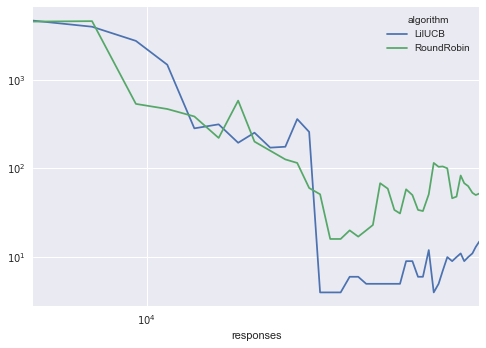

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from altair import Chart, Y, Scale
plt.style.use('seaborn')

df = performance.pivot_table(values='top captions', columns='algorithm', index='responses')
df.plot(logy=True, logx=True)